# **Spatial-Spectral Summarizer Fusion Network (S³F-Net)**

This notebook contains the full implementation of **S³F-Net** on the HAM10000 (Skin Lesion Segmentation/Classification) dataset (This is the final implementation after the model/hyperparameter tuning was finalized. The tuning process was also carried out primarily using the original HAM10000 dataset). We use the **SpectraNet-1** variant as the spectral encoder here, and use a powerful **Bilinear Fusion** to fuse the two branches (Spatial & Spectral). The full architecture is customizable, feel free to do so. Edit the file paths according to your setup.

## **Data Preparation**

In [ ]:
# ====================
# BLOCK 1: SETUP
# ====================

import os
import zipfile
from google.colab import drive

print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# --- Defining Paths ---
ZIP_PATH = "/content/drive/MyDrive/Medical Image Segmentation/HAM10000.zip"
TEMP_DATA_DIR = "/content/ham10000_temp"

# --- Unzip the Data ---
if not os.path.exists(TEMP_DATA_DIR):
    print(f"\n--- Unzipping dataset to local runtime for fast access... ---")
    os.makedirs(TEMP_DATA_DIR, exist_ok=True)
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(TEMP_DATA_DIR)
        print("\n--- Unzipping complete! ---")
    except Exception as e:
        print(f"ERROR: Could not unzip file. Check ZIP_PATH. Error: {e}")
        exit()
else:
    print("\n--- Dataset already unzipped in this session. ---")

--- Mounting Google Drive ---
Mounted at /content/drive

--- Unzipping dataset to local runtime for fast access... ---

--- Unzipping complete! ---


In [ ]:
# ==============================================================================
# BLOCK 2: IMPORTS AND CONFIGURATION
# ==============================================================================
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
IMG_SIZE = (225, 300)
BATCH_SIZE = 16
EPOCHS = 200
RANDOM_STATE = 42

# --- Paths ---
DATASET_BASE_PATH = "/content/ham10000_temp/HAM10000"
SAVE_FOLDER = "/content/drive/MyDrive/S3F_Net_Models"
os.makedirs(SAVE_FOLDER, exist_ok=True)
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "Bilinear_S3f_net_SN1_HAM10000.keras")

In [ ]:
# ==========================
# BLOCK 3: DATA LOADING
# ==========================
def load_ham10000_split(base_path, csv_filename, image_foldername):
    """Loads a specific split (train or test) of the HAM10000 dataset."""
    csv_path = os.path.join(base_path, csv_filename)
    image_dir = os.path.join(base_path, image_foldername)
    df = pd.read_csv(csv_path)
    class_names = list(df.columns[1:])
    labels_one_hot = df.iloc[:, 1:].values
    labels_int = np.argmax(labels_one_hot, axis=1)
    images = []
    image_ids = df['image'].values
    print(f"Loading {len(image_ids)} images from: {image_dir}")
    for img_id in image_ids:
        img_path = os.path.join(image_dir, f"{img_id}.jpg")
        try:
            img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_AREA)
            img = img.astype('float32') / 255.0
            images.append(img)
        except Exception: continue
    return np.array(images), np.array(labels_int), class_names

try:
    # --- Loading the two separate datasets ---
    X_train, y_train, CLASS_NAMES = load_ham10000_split(DATASET_BASE_PATH, 'GroundTruth.csv', 'images')
    X_test, y_test, _ = load_ham10000_split(DATASET_BASE_PATH, 'Test_GroundTruth.csv', 'Test_images')   # The Test set is basically the Test set provided for ISIC Challenge 2018.

    print("\n--- Data Loading Summary ---")
    print(f"Training set:   {len(X_train)} samples")
    print(f"Test set:       {len(X_test)} samples")
    print(f"Class names:    {CLASS_NAMES}")

    # Calculating class weights from the training set
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))
    print(f"Calculated class weights: {class_weights_dict}")
    print("\nData is ready for model training.")

except Exception as e:
    print(f"An error occurred during data loading: {e}"); exit()

Loading 10015 images from: /content/ham10000_temp/HAM10000/images
Loading 1512 images from: /content/ham10000_temp/HAM10000/Test_images

--- Data Loading Summary ---
Training set:   10015 samples
Test set:       1512 samples (will be used for validation and final testing)
Class names:    ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
Calculated class weights: {0: np.float64(1.2854575792581184), 1: np.float64(0.21338020666879728), 2: np.float64(2.78349082823791), 3: np.float64(4.375273044997815), 4: np.float64(1.301832835044846), 5: np.float64(12.440993788819876), 6: np.float64(10.075452716297788)}

Data is ready for model training.


## **S³F-Net (Bilinear-Fusion SN1 Variant) Model Building**

In [1]:
# ==============================================================================
# BLOCK 3: MODEL ARCHITECTURE (BILINEAR FUSION FOR HAM10000)
# ==============================================================================
# This block defines the S³F-Net with SpectraNet-1 + Bilinear Fusion

# --- Custom SpectralFilter Layer & Encoders ---
class SpectralFilterLayer(layers.Layer):
    def __init__(self, filters, **kwargs): super().__init__(**kwargs); self.filters = filters
    def build(self, input_shape):
        _, h, w, c = input_shape
        fft_shape = (h, w // 2 + 1)
        self.real_weights = self.add_weight(name='real_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.imag_weights = self.add_weight(name='imag_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.bias = self.add_weight(name='bias', shape=(self.filters,), initializer='zeros')
    def call(self, inputs):
        inputs_p = tf.transpose(inputs, [0, 3, 1, 2])
        inputs_fft = tf.signal.rfft2d(inputs_p)
        kernel_fft = tf.complex(self.real_weights, self.imag_weights)
        output_fft = tf.einsum('bchw,cfhw->bfhw', inputs_fft, kernel_fft)
        output_s = tf.signal.irfft2d(output_fft)
        output_p = tf.transpose(output_s, [0, 2, 3, 1])
        return output_p + self.bias
    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

class BilinearFusion(layers.Layer):
    """Performs a full bilinear fusion with normalization."""
    def call(self, inputs):
        spatial_vector, spectral_vector = inputs
        spatial_reshaped = tf.expand_dims(spatial_vector, axis=-1)
        spectral_reshaped = tf.expand_dims(spectral_vector, axis=-1)
        outer_product = tf.matmul(spatial_reshaped, spectral_reshaped, transpose_b=True)
        bilinear_vector = layers.Flatten()(outer_product)
        bilinear_vector = tf.sign(bilinear_vector) * tf.sqrt(tf.abs(bilinear_vector) + 1e-5)
        bilinear_vector = tf.nn.l2_normalize(bilinear_vector, axis=-1)
        return bilinear_vector
    def compute_output_shape(self, input_shape):
        spatial_shape, spectral_shape = input_shape
        return (spatial_shape[0], spatial_shape[1] * spectral_shape[1])

def build_spatial_encoder(inputs):
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    return x

def depthwise_sep_block(x, filters, kernel_size=3, strides=1):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def build_spectral_summary_branch(inputs):
    x = SpectralFilterLayer(32)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = depthwise_sep_block(x, 64)
    x = layers.MaxPooling2D(2)(x)

    x = depthwise_sep_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1875)(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3125)(x)

    return x

# --- S³F-Net Model Builder with Bilinear Fusion ---
def build_s3f_net_bilinear(input_shape, num_classes):
    """Builds the S³F-Net with Bilinear fusion for classification."""
    inputs = layers.Input(input_shape)

    # --- Tower 1: Deep Spatial Branch ---
    spatial_features = build_spatial_encoder(inputs)
    spatial_vector_raw = layers.GlobalAveragePooling2D()(spatial_features)
    spatial_refined = layers.Dense(512, activation='relu')(spatial_vector_raw)
    spatial_refined = layers.BatchNormalization()(spatial_refined)
    spatial_refined = layers.Dropout(0.5)(spatial_refined)

    # --- Tower 2: Spectral Summary Branch ---
    spectral_summary_vector = build_spectral_summary_branch(inputs)

    # --- Bilinear Fusion ---
    bilinear_vector = BilinearFusion()([spatial_refined, spectral_summary_vector])

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(bilinear_vector)

    model = models.Model(inputs, outputs, name="S3F_Net_Bilinear")

    # Compiling with CE loss
    model.compile(optimizer=optimizers.Adam(0.0003),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("Bilinear Fusion S³F-Net model architecture is ready for HAM10000.")

Bilinear Fusion S³F-Net model architecture is ready for HAM10000.


## **Model Training**

In [ ]:
# ======================================
# BLOCK 4: CUSTOM CALLBACK AND TRAINING
# ======================================
from sklearn.metrics import f1_score

# --- Custom F1 Score Callback to use 'weighted' average ---
class F1ScoreCallback(callbacks.Callback):
    def __init__(self, validation_data, filepath, patience=25):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.filepath = filepath
        self.patience = patience
        self.best_f1 = -1.0
        self.wait = 0
    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data; y_pred_proba = self.model.predict(X_val, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        weighted_f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        logs['val_f1_weighted'] = weighted_f1
        print(f" - val_f1_weighted: {weighted_f1:.4f}", end="")
        if weighted_f1 > self.best_f1:
            print(f" (New best F1, saving model to {self.filepath})")
            self.best_f1 = weighted_f1
            self.model.save(self.filepath)
            self.wait = 0
        else:
            print()
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping triggered based on weighted F1-score.")
                self.model.stop_training = True

# --- Defining the model path ---
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "Bilinear_S3f_net_SN1_HAM10000.keras")

# --- Building the Model ---
print("\n--- Building Bilinear Fusion S³F-Net ---")
classifier_model = build_s3f_net_bilinear(X_train.shape[1:], num_classes=len(CLASS_NAMES))
classifier_model.summary()

# --- Callbacks ---
f1_callback = F1ScoreCallback(validation_data=(X_test, y_test),
                              filepath=CLASSIFIER_MODEL_PATH,
                              patience=40)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=20,
                                        min_lr=1e-6,
                                        verbose=1)

# --- Training the Model ---
print("\n--- Training Bilinear Fusion S³F-Net ---")
history = classifier_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[f1_callback, reduce_lr]
)

print("\n--- Training Finished ---")


--- Building Final Bilinear Fusion S²F-Net ---


Model: "S2F_Net_Bilinear_Final"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 225, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 225, 300,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 225, 300,  │      9,248 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 225, 300,  │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 225, 300,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 112, 150,  │          0 │ activation_4[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_conv_laye… │ (None, 225, 300,  │  6,523,232 │ input_layer_1[0]… │
│ (SpectralConvLayer) │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 112, 150,  │          0 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 225, 300,  │        128 │ spectral_conv_la… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 112, 150,  │     18,496 │ dropout_7[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 225, 300,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 112, 150,  │     36,928 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_2  │ (None, 225, 300,  │        288 │ re_lu_5[0][0]     │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 150,  │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 225, 300,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 112, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 225, 300,  │          0 │ batch_normalizat

 Total params: 7,859,979 (29.98 MB)

 Trainable params: 7,857,315 (29.97 MB)

 Non-trainable params: 2,664 (10.41 KB)


--- Training Final Bilinear Fusion S²F-Net ---
Epoch 1/200
626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.1593 - loss: 1.8660 - val_f1_weighted: 0.0720 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/final_bilinear_s2f_net.keras)
626/626 ━━━━━━━━━━━━━━━━━━━━ 107s 115ms/step - accuracy: 0.1593 - loss: 1.8661 - val_accuracy: 0.1475 - val_loss: 2.0392 - val_f1_weighted: 0.0720 - learning_rate: 3.0000e-04
Epoch 2/200
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2413 - loss: 1.8311 - val_f1_weighted: 0.4694 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/final_bilinear_s2f_net.keras)
626/626 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.2414 - loss: 1.8310 - val_accuracy: 0.4345 - val_loss: 1.7168 - val_f1_weighted: 0.4694 - learning_rate: 3.0000e-04
Epoch 3/200
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3122 - loss: 1.7712 - val_f1_weighted: 0.2234
626/626 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.3122 - lo

## **Evaluation**



--- Final Evaluation on Unseen Test Set ---
--- Rebuilding the S²F-Net architecture to load weights ---
Loading trained weights from: /content/drive/MyDrive/S2F_Net_Models/final_bilinear_s2f_net.keras

--- Calculating Loss and Accuracy on Test Set ---
Test Loss:      1.1984
Test Accuracy:  0.6931
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step

--- Detailed Performance Metrics ---
Macro F1 Score:   0.5149
Weighted F1 Score:0.7047
Cohen's Kappa:    0.5153
MCC:              0.5185
AUC-ROC (Macro):  0.8811
AUC-ROC (Weighted):  0.8835

--- Classification Report ---
              precision    recall  f1-score   support

         MEL     0.4532    0.5380    0.4920       171
          NV     0.8947    0.7943    0.8415       909
         BCC     0.4014    0.6129    0.4851        93
       AKIEC     0.4419    0.4419    0.4419        43
         BKL     0.5353    0.5945    0.5633       217
          DF     0.2917    0.3182    0.3043        44
        VASC     0.5357    0.4286    0.4762        35

    

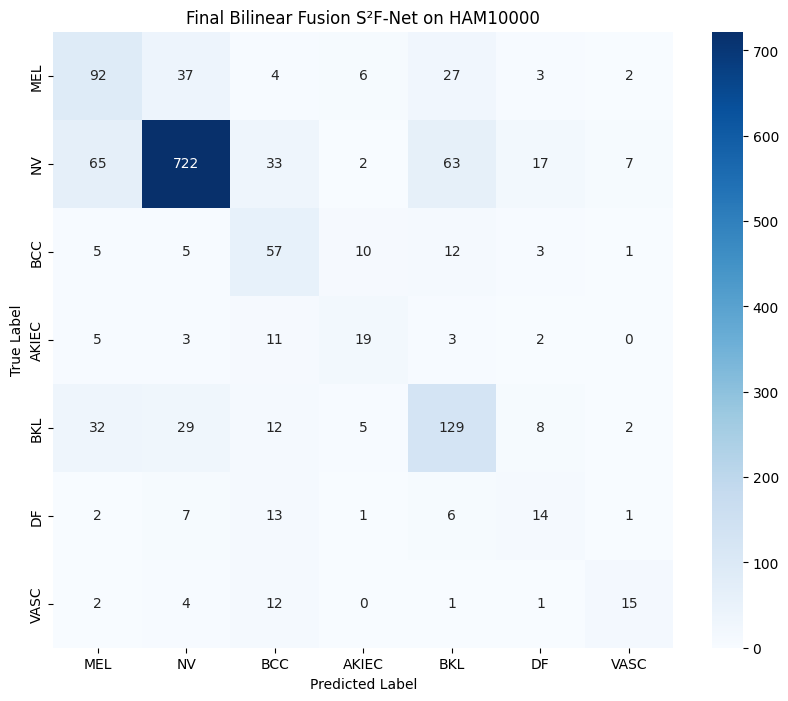


--- Training History Plots ---


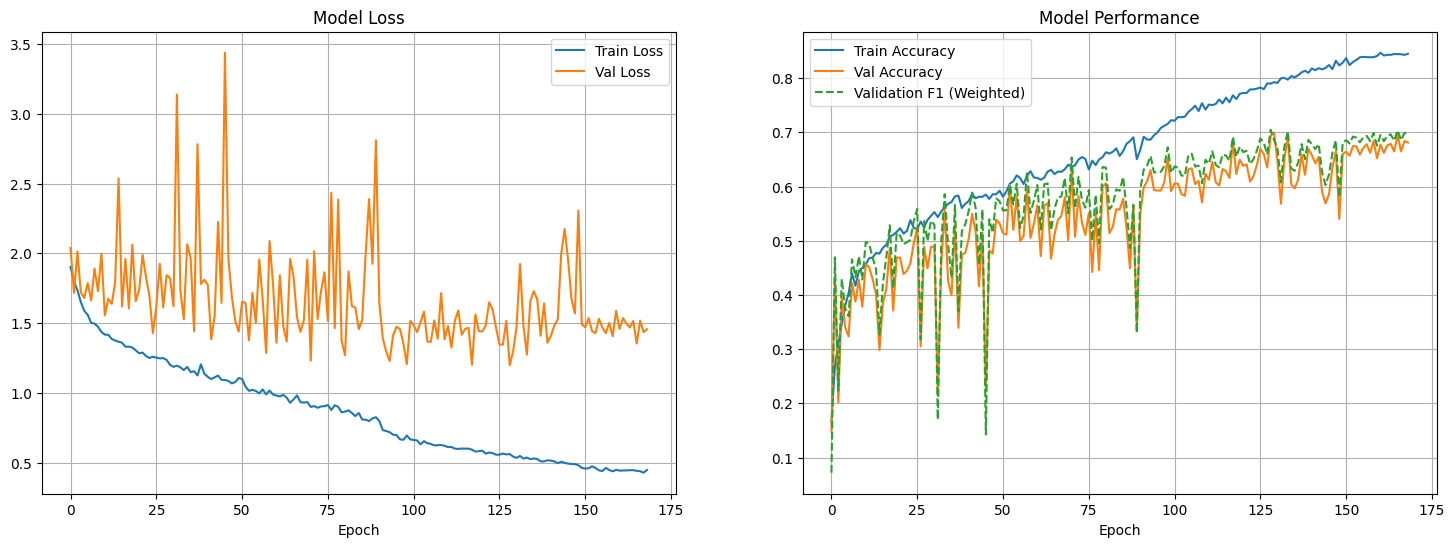


--- ROC Curve Analysis ---


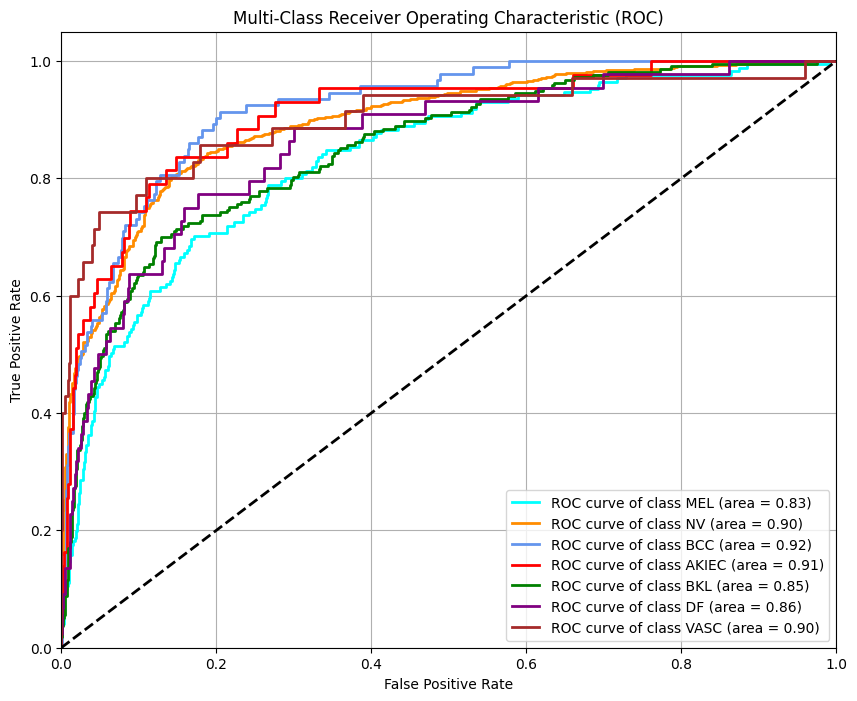


--- Script Finished ---


In [ ]:
# ===========================
# BLOCK 6: EVALUATION
# ===========================

print("\n\n--- Final Evaluation on the Test Set ---")
custom_objects = {
    'SpectralFilterLayer': SpectralFilterLayer,
    'BilinearFusion': BilinearFusion
}

try:
    print(f"Loading best model from: {CLASSIFIER_MODEL_PATH}")
    best_model = models.load_model(
        CLASSIFIER_MODEL_PATH,
        custom_objects = custom_objects}
    )

    # --- 1. Evaluating Loss and Accuracy ---
    print("\n--- Calculating Loss and Accuracy on Test Set ---")
    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss:      {loss:.4f}")
    print(f"Test Accuracy:  {accuracy:.4f}")

    # --- 2. Getting Predictions ---
    y_pred_proba = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    # --- 3. Detailed Metrics ---
    print("\n--- Detailed Performance Metrics ---")
    macro_f1 = f1_score(y_test, y_pred_classes, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    print(f"Macro F1 Score:   {macro_f1:.4f}")
    print(f"Weighted F1 Score:{weighted_f1:.4f}")

    kappa = cohen_kappa_score(y_test, y_pred_classes)
    mcc = matthews_corrcoef(y_test, y_pred_classes)
    print(f"Cohen's Kappa:    {kappa:.4f}")
    print(f"MCC:              {mcc:.4f}")

    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    weighted_auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (Macro):  {auc_roc:.4f}")
    print(f"AUC-ROC (Weighted):{weighted_auc_roc:.4f}")

    # --- 4. Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES, digits=4, zero_division=0))

    # --- 5. Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.title('Bilinear Fusion S³F-Net on HAM10000')
    plt.show()

    # --- 6. Plotting Training History ---
    if 'history' in locals() or 'history' in globals():
        print("\n--- Training History Plots ---")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        ax1.plot(history.history['loss'], label='Train Loss')
        ax1.plot(history.history['val_loss'], label='Val Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True)
        ax2.plot(history.history['accuracy'], label='Train Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
        if 'val_f1_weighted' in history.history:
            ax2.plot(history.history['val_f1_weighted'], label='Validation F1 (Weighted)', linestyle='--')
        ax2.set_title('Model Performance')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True)
        plt.show()

    # --- 7. ROC Curve Plot ---
    print("\n--- ROC Curve Analysis ---")
    y_test_binarized = label_binarize(y_test, classes=range(len(CLASS_NAMES)))
    n_classes = y_test_binarized.shape[1]
    fpr, tpr, roc_auc_dict = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {CLASS_NAMES[i]} (area = {roc_auc_dict[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Multi-Class Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred during evaluation: {e}")

print("\n--- Script Finished ---")